#Necessary imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install -q lightly

In [4]:
import numpy as np
import pandas as pd
import copy
import torch
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import torch
import torchvision

from torch import nn
from torchvision import transforms

from lightly.loss import NTXentLoss
from lightly.models.modules import SimCLRProjectionHead
from lightly.transforms.simclr_transform import SimCLRTransform

from lightly.data import LightlyDataset
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [5]:
def reproducibility(SEED):
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)

reproducibility(1000)

#Define model

In [ ]:
class SimCLR(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimCLRProjectionHead(512, 512, 128)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

In [7]:
# !pip install -U openmim && mim install "mmpretrain>=1.0.0rc8"

In [32]:
from mmpretrain import get_model

model = get_model('vit-small-p14_dinov2-pre_3rdparty', pretrained=True)
model = model.to(DEVICE)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpretrain/v1.0/dinov2/vit-small-p14_dinov2-pre_3rdparty_20230426-5641ca5a.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: backbone.mask_token



#Data (cifar10 or cifar100)

In [9]:
def get_input_stats(dataset):
    if dataset == 'cifar_100':
        data_mean, data_std = (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
    elif dataset == 'cifar_10':
        data_mean, data_std = (0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)

    return data_mean, data_std

In [ ]:
# resnet = torchvision.models.resnet18()
# backbone = nn.Sequential(*list(resnet.children())[:-1])
# model = SimCLR(backbone)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

Files already downloaded and verified


In [11]:
from lightly.transforms.dino_transform import DINOTransform

In [22]:
transform = SimCLRTransform(input_size=32, gaussian_blur=0.0)
cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", download=True)

data_mean, data_std = get_input_stats('cifar_10')
normalize_dict = {'mean': data_mean, 'std': data_std}

dataset = LightlyDataset.from_torch_dataset(cifar10, transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)

Files already downloaded and verified


#Optimizer and Scheduler

In [33]:
criterion = NTXentLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.85)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr=0.001, max_lr=0.1)
n_epochs, max_norm = 20, 0.1

#KNN and dataloaders for evaluation

In [14]:
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

BATCH_SIZE = 128

test_transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

def get_cifar10_dataloader(batch_size, train=True, transform=test_transform):
    dataset = CIFAR10(root="./", train=train, transform=transform, download=True)
    return DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4, drop_last=True)


loader_train_plain = get_cifar10_dataloader(batch_size=BATCH_SIZE, train=True, transform=test_transform)
loader_test = get_cifar10_dataloader(batch_size=BATCH_SIZE, train=False, transform=test_transform)

100%|██████████| 170498071/170498071 [00:12<00:00, 13250077.01it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [15]:
class KNN():
    def __init__(self, model, k, device):
        super(KNN, self).__init__()
        self.k = k
        self.device = device
        self.model = model.to(device)
        self.model.eval()

    def extract_features(self, loader):
        x_lst = []
        features = []
        label_lst = []

        with torch.no_grad():
            for input_tensor, label in loader:
                # h = self.model(input_tensor.to(self.device))
                h = self.model.extract_feat(input_tensor.to(self.device))[0]
                features.append(h)
                x_lst.append(input_tensor)
                label_lst.append(label)

            x_total = torch.stack(x_lst)
            h_total = torch.stack(features)
            label_total = torch.stack(label_lst)

            return x_total, h_total, label_total

    def knn(self, features, labels, k=1):
        """
        Evaluating knn accuracy in feature space.
        Calculates only top-1 accuracy (returns 0 for top-5)
        Args:
            features: [... , dataset_size, feat_dim]
            labels: [... , dataset_size]
            k: nearest neighbours
        Returns: train accuracy, or train and test acc
        """
        feature_dim = features.shape[-1]
        with torch.no_grad():
            features_np = features.cpu().view(-1, feature_dim).numpy()
            labels_np = labels.cpu().view(-1).numpy()
            # fit
            self.cls = KNeighborsClassifier(k, metric='cosine').fit(features_np, labels_np)
            acc = self.eval(features, labels)

        return acc

    def eval(self, features, labels):
      feature_dim = features.shape[-1]
      features = features.cpu().view(-1, feature_dim).numpy()
      labels = labels.cpu().view(-1).numpy()
      acc = 100 * np.mean(cross_val_score(self.cls, features, labels))
      return acc

    def _find_best_indices(self, h_query, h_ref):
        h_query = h_query / h_query.norm(dim=1).view(-1, 1)
        h_ref = h_ref / h_ref.norm(dim=1).view(-1, 1)
        scores = torch.matmul(h_query, h_ref.t())  # [query_bs, ref_bs]
        score, indices = scores.topk(1, dim=1)  # select top k best
        return score, indices

    def fit(self, train_loader, test_loader=None):
        with torch.no_grad():
            x_train, h_train, l_train = self.extract_features(train_loader)
            train_acc = self.knn(h_train, l_train, k=self.k)

            if test_loader is not None:
                x_test, h_test, l_test = self.extract_features(test_loader)
                test_acc = self.eval(h_test, l_test)
                return train_acc, test_acc

#Make directory for saving models & Training

In [16]:
!mkdir models

In [17]:
ssl_evaluator = KNN(model=model, k=1, device='cuda')
train_acc, val_acc = ssl_evaluator.fit(loader_train_plain, loader_test)
print(train_acc, val_acc)

50.44270833333333 43.54967822475196


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
best_val_acc = 0

print("Starting Training")
for epoch in tqdm(range(n_epochs)):
    total_loss = 0
    for batch in dataloader:
        x0, x1 = batch[0]
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model.extract_feat(x0)[0]
        z1 = model.extract_feat(x1)[0]
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"\n epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    ssl_evaluator = KNN(model=model, k=1, device='cuda')
    train_acc, val_acc = ssl_evaluator.fit(loader_train_plain, loader_test)
    if val_acc > best_val_acc:
        torch.save(model.state_dict(),f'models/dino_model_acc{val_acc:.2f}.pt')
        best_val_acc = val_acc
    print(f'\n Train Accuracy:{train_acc:.1f}%',f' Val Accuracy:{val_acc:.1f}%')

Starting Training


  0%|          | 0/20 [00:00<?, ?it/s]


 epoch: 00, loss: 4.89493


  5%|▌         | 1/20 [03:14<1:01:41, 194.81s/it]


 Train Accuracy:54.7%  Val Accuracy:49.5%

 epoch: 01, loss: 4.63106


 10%|█         | 2/20 [06:25<57:40, 192.26s/it]  


 Train Accuracy:58.0%  Val Accuracy:52.5%

 epoch: 02, loss: 4.54297


 15%|█▌        | 3/20 [09:37<54:31, 192.43s/it]


 Train Accuracy:59.3%  Val Accuracy:55.1%

 epoch: 03, loss: 4.48665


 20%|██        | 4/20 [12:48<51:05, 191.57s/it]


 Train Accuracy:60.7%  Val Accuracy:55.2%

 epoch: 04, loss: 4.44242


 25%|██▌       | 5/20 [15:58<47:47, 191.17s/it]


 Train Accuracy:60.9%  Val Accuracy:55.8%

 epoch: 05, loss: 4.42318


 30%|███       | 6/20 [19:19<45:20, 194.31s/it]


 Train Accuracy:61.6%  Val Accuracy:56.3%

 epoch: 06, loss: 4.39987


 35%|███▌      | 7/20 [22:36<42:18, 195.26s/it]


 Train Accuracy:62.5%  Val Accuracy:57.5%

 epoch: 07, loss: 4.38610


 40%|████      | 8/20 [26:01<39:42, 198.57s/it]


 Train Accuracy:62.2%  Val Accuracy:57.5%

 epoch: 08, loss: 4.36352


 45%|████▌     | 9/20 [29:05<35:33, 193.97s/it]


 Train Accuracy:63.1%  Val Accuracy:58.6%

 epoch: 09, loss: 4.35010


 50%|█████     | 10/20 [32:19<32:20, 194.01s/it]


 Train Accuracy:62.8%  Val Accuracy:57.8%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fcf957d090>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fcf957d090>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
:     can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


 epoch: 10, loss: 4.34330


 55%|█████▌    | 11/20 [35:30<28:56, 192.94s/it]


 Train Accuracy:63.2%  Val Accuracy:58.1%

 epoch: 11, loss: 4.33703


 60%|██████    | 12/20 [38:39<25:33, 191.75s/it]


 Train Accuracy:63.3%  Val Accuracy:59.2%

 epoch: 12, loss: 4.32798


 65%|██████▌   | 13/20 [41:44<22:08, 189.73s/it]


 Train Accuracy:62.9%  Val Accuracy:58.1%

 epoch: 13, loss: 4.31738


 70%|███████   | 14/20 [44:48<18:47, 187.92s/it]


 Train Accuracy:64.4%  Val Accuracy:60.1%


#Load best model we have got

In [ ]:
model.load_state_dict(torch.load('models/SimCLR_model_acc38.23.pt'))

<All keys matched successfully>

#Visual evaluation

In [13]:
transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])

dataset = LightlyDataset.from_torch_dataset(cifar10, transform=transform_clean)

dataloader_test = torch.utils.data.DataLoader(
    dataset, batch_size=128, shuffle=False, drop_last=True, num_workers=1,
)

In [15]:
def generate_embeddings(model, dataloader):
    embeddings, filenames, labels = [], [], []
    with torch.no_grad():
        for img, label, fnames in dataloader:
            img = img.to(DEVICE)
            emb = model.extract_feat(img)[0].flatten(start_dim=1).cpu()
            embeddings.append(emb)
            filenames.extend(fnames)
            labels.extend(label)
            break

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames, labels

# backbone.eval()
backbone = model# model.backbone
backbone.eval()
embeddings, filenames, labels = generate_embeddings(backbone, dataloader_test)

In [16]:
def class_name(index):
    return cifar10.classes[index.item()]

In [17]:
path_to_data = '/content/datasets/' + 'cifar10'

def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
#     img = Image.open(filename)
#     return np.asarray(img)
    img = dataset[int(filename)][0]
    return np.clip(img.permute(1, 2, 0).numpy(),0,1)

def plot_knn_examples(embeddings, filenames, labels, n_neighbors=5, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples; we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get n random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    fig,axes = plt.subplots(num_examples,n_neighbors,figsize=(40,40),constrained_layout=True)
    for example_index,idx in tqdm(enumerate(samples_idx)):
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            image = get_image_as_np_array(filenames[neighbor_idx])
            axes[example_index,plot_x_offset].imshow(image)
            axes[example_index,plot_x_offset].set_title(class_name(labels[neighbor_idx]) + ' ' + f"d={distances[idx][plot_x_offset]:.3f}")
            plt.axis("off")
    plt.savefig('knn_examples.png')

5it [00:00, 87.68it/s]


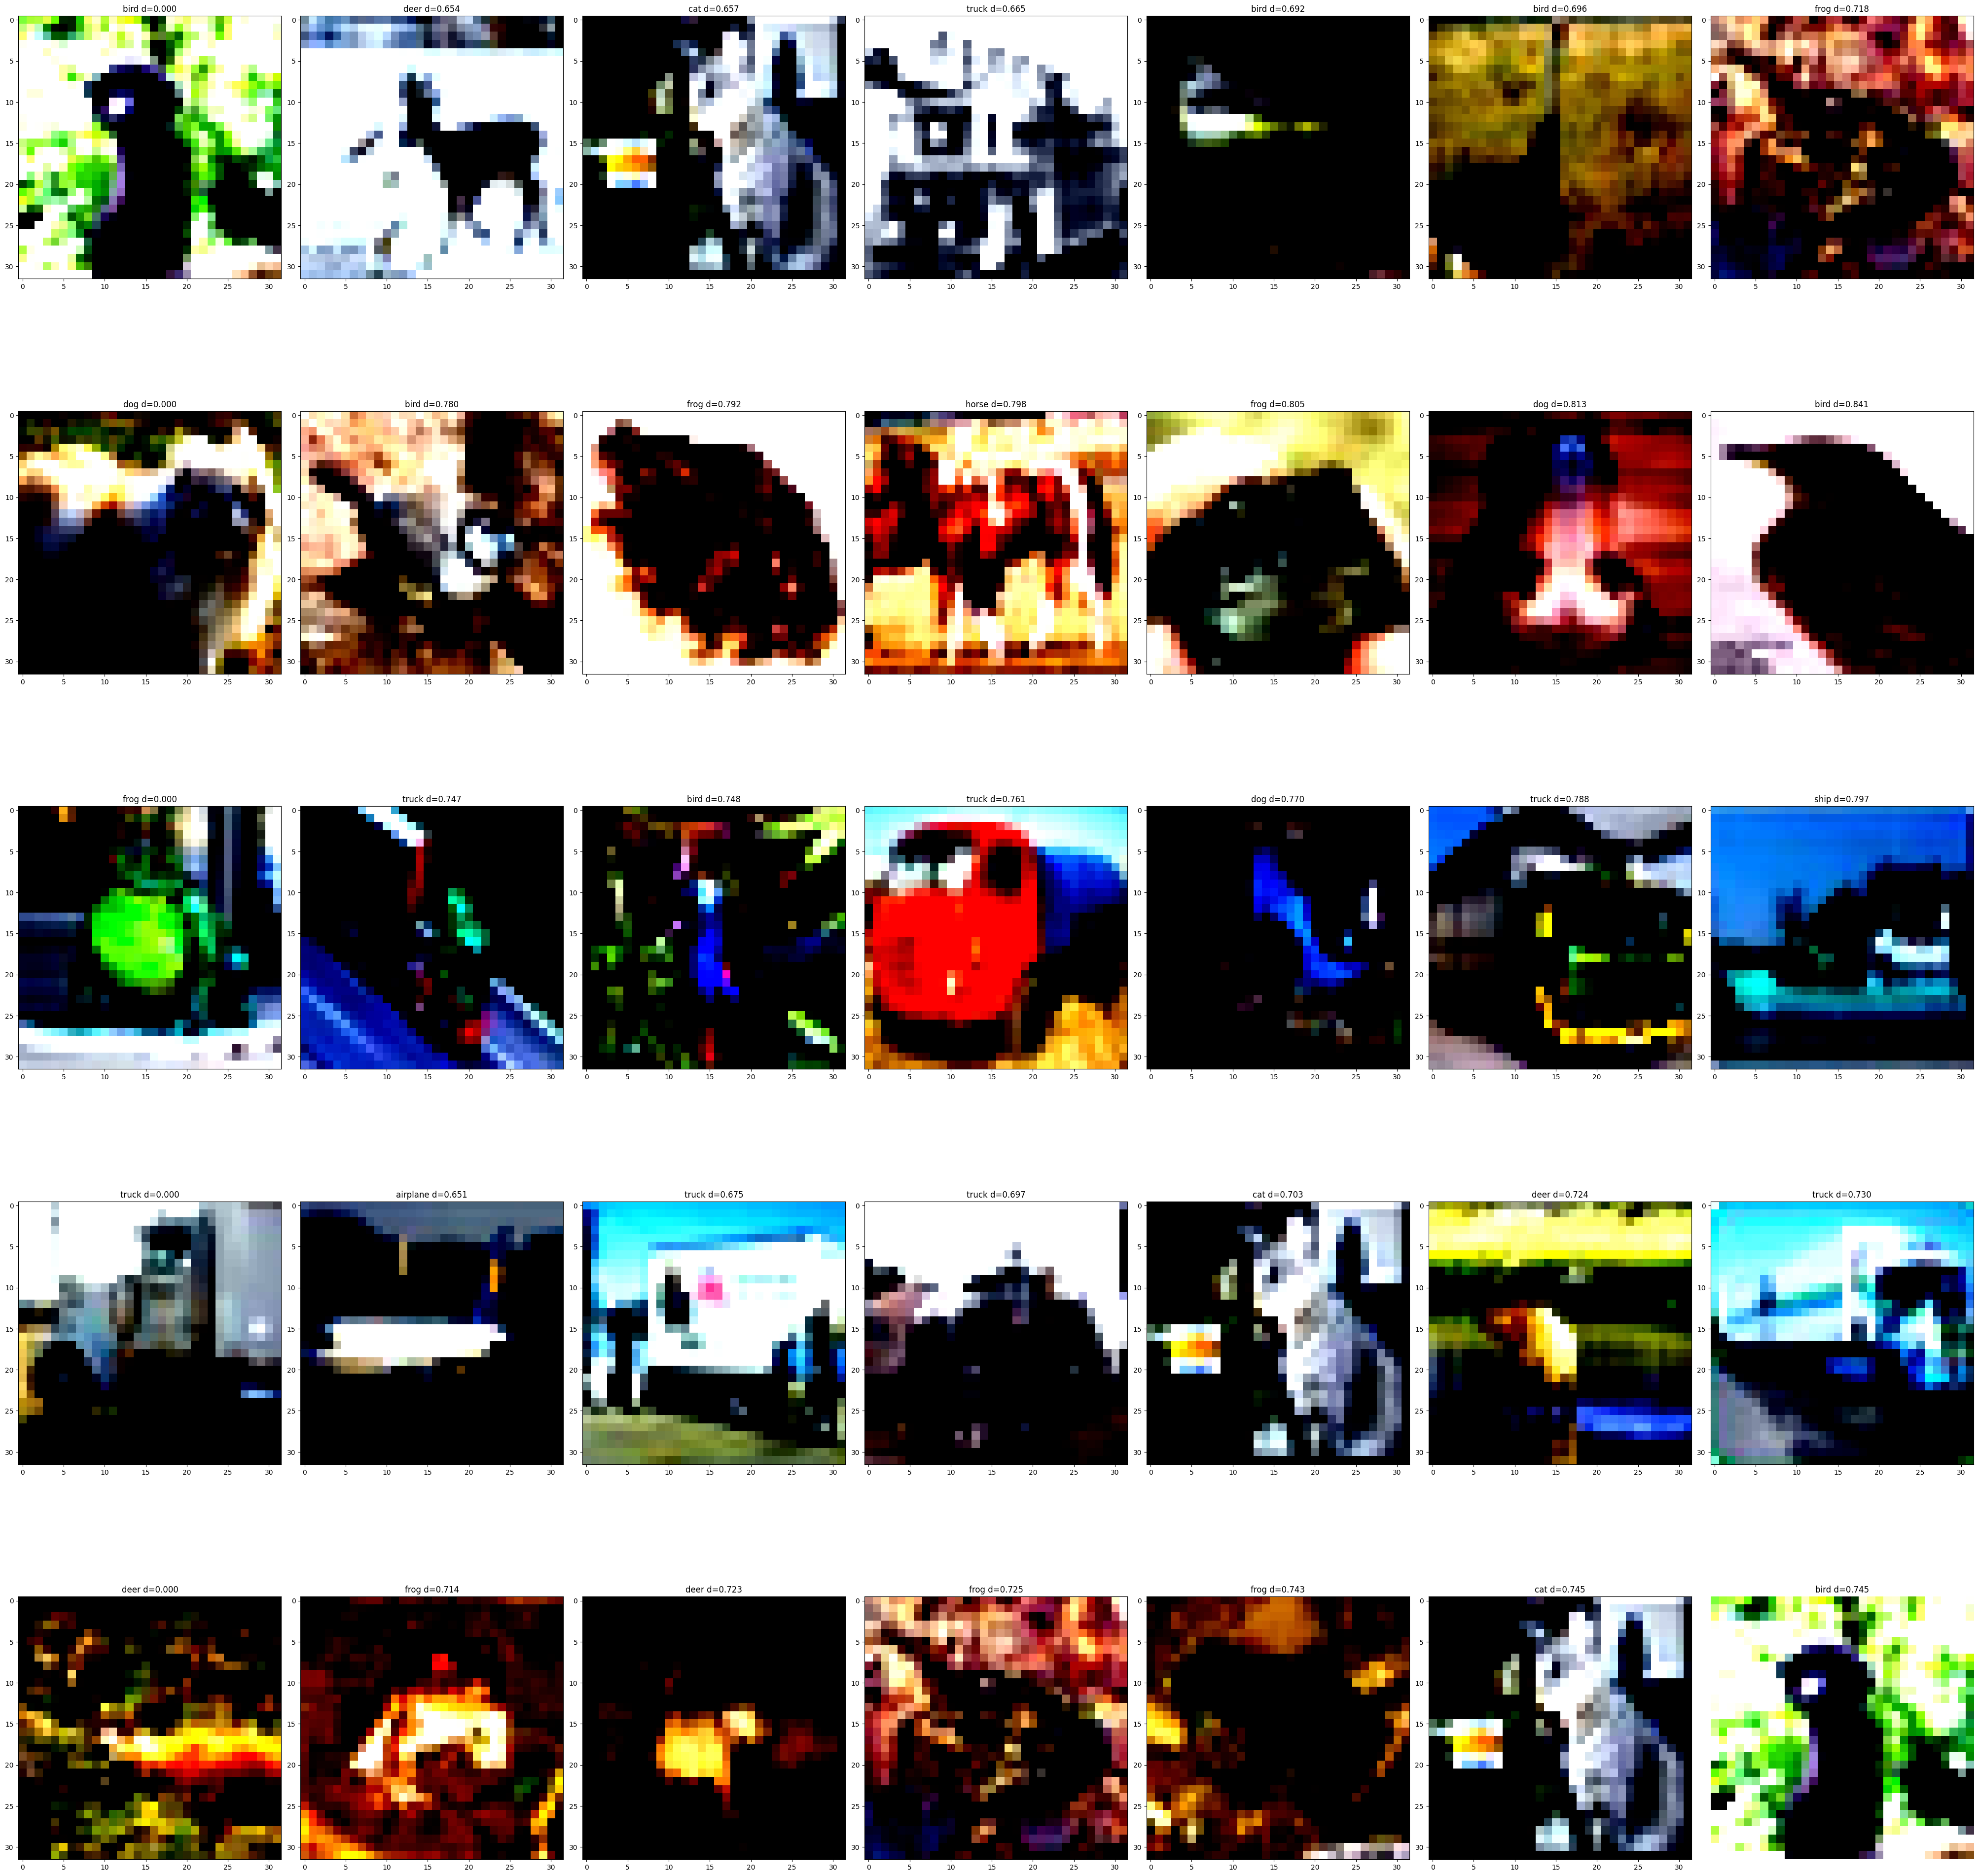

In [21]:
plot_knn_examples(embeddings, filenames, labels, num_examples=5, n_neighbors=7)

#Save backbone model

In [ ]:
torch.save(backbone.state_dict(), 'model_cifar_10_SimCLR38.23.pt')